<a href="https://colab.research.google.com/github/takeisika/morphological-computation/blob/main/morphological_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[INFO] device = cuda

=== Training Controllers ===
[NN-dominant] iter 001/80 | loss=6.5191e+00 | band(final)=0.178 band_abs(final)=6.49e-03 gate=0.09 ΔV_tail=8.33e-04 sustain(norm)=2.12e-01 ctrlL1=5.16e-03 ctrlTV=0.00e+00
[NN-dominant] iter 016/80 | loss=1.1188e+00 | band(final)=0.137 band_abs(final)=4.19e-03 gate=0.01 ΔV_tail=5.21e-04 sustain(norm)=2.71e-01 ctrlL1=5.00e-02 ctrlTV=0.00e+00
[NN-dominant] iter 032/80 | loss=2.7665e+00 | band(final)=0.185 band_abs(final)=2.27e-03 gate=0.13 ΔV_tail=2.39e-04 sustain(norm)=2.93e-02 ctrlL1=1.15e-01 ctrlTV=0.00e+00
[NN-dominant] iter 048/80 | loss=1.0291e+00 | band(final)=0.097 band_abs(final)=4.39e-03 gate=0.00 ΔV_tail=7.09e-04 sustain(norm)=5.55e-01 ctrlL1=1.12e-01 ctrlTV=0.00e+00
[NN-dominant] iter 064/80 | loss=9.4043e-01 | band(final)=0.089 band_abs(final)=2.19e-03 gate=0.00 ΔV_tail=4.04e-04 sustain(norm)=5.01e-01 ctrlL1=1.12e-01 ctrlTV=0.00e+00
[NN-dominant] iter 080/80 | loss=9.1394e-01 | band(final)=0.090 band_abs(final)=1.86e-03 gate=

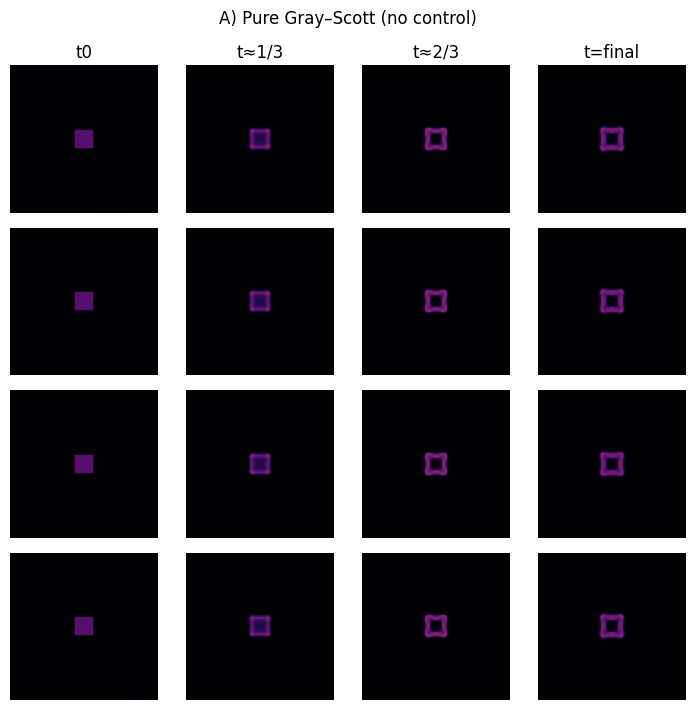

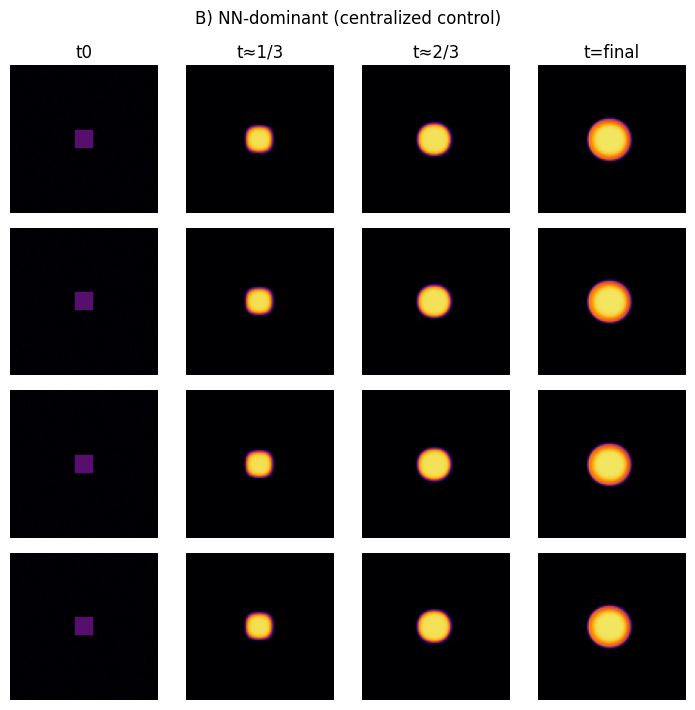

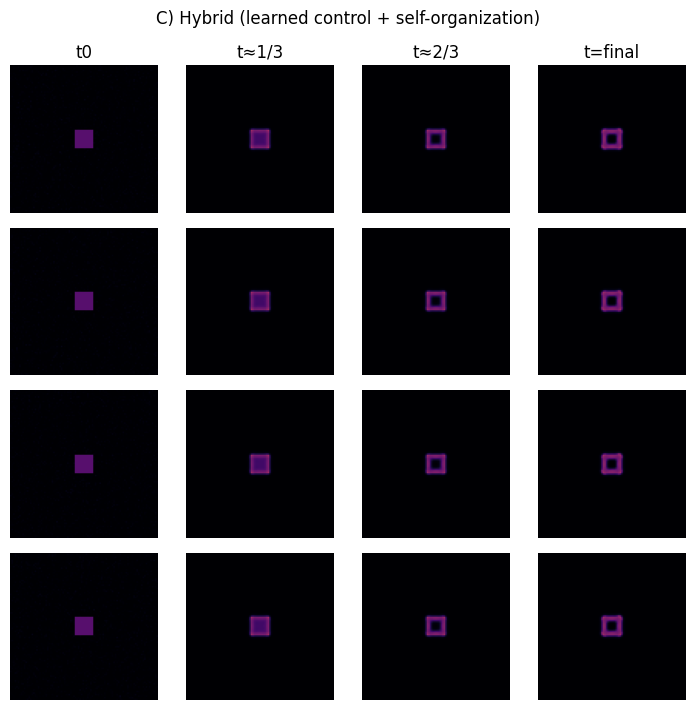

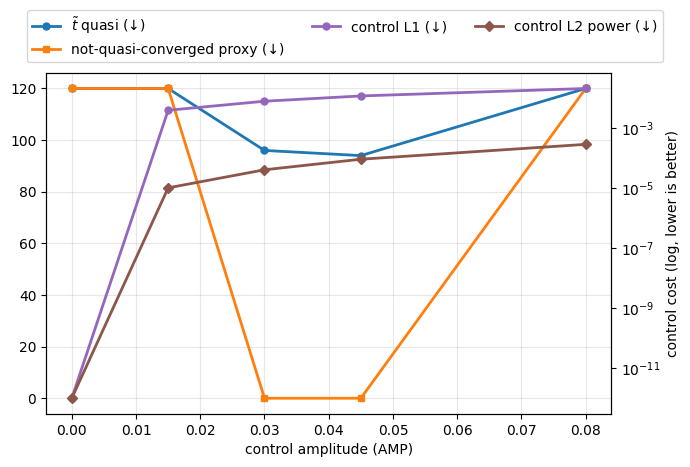

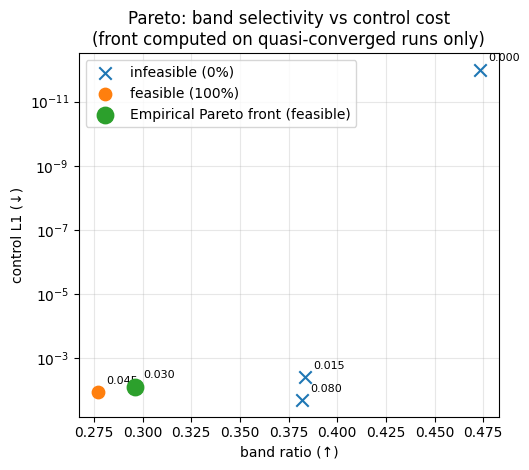


[SCAN] AMP sweep (Hybrid controller weights, quasi-stability v2)
 AMP=0.000: t~=120.0  quasi-converged=0.0% band=0.473 band_abs=6.44e-04 ctrlL1=0.000e+00 ctrlL2=0.000e+00
 AMP=0.015: t~=120.0  quasi-converged=0.0% band=0.383 band_abs=5.11e-04 ctrlL1=3.963e-03 ctrlL2=1.029e-05
 AMP=0.030: t~=96.0  quasi-converged=100.0% band=0.296 band_abs=4.55e-04 ctrlL1=7.928e-03 ctrlL2=4.115e-05
 AMP=0.045: t~=94.0  quasi-converged=100.0% band=0.277 band_abs=4.77e-04 ctrlL1=1.189e-02 ctrlL2=9.247e-05
 AMP=0.080: t~=120.0  quasi-converged=0.0% band=0.382 band_abs=5.79e-04 ctrlL1=2.108e-02 ctrlL2=2.897e-04

=== Done ===


In [ ]:
# ====================================================
# Hybrid Morphogenesis (Gray–Scott × Neural Controller)
# v4.1: dtype-safe init + long-horizon curriculum + time-decay AMP
# ====================================================

import math, time, random, os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ----------------- Reproducibility -----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------- Speed presets -------------------
FAST_DEMO = False   # CPUなら True に

# ----------------- Global Parameters -----------------
H, W = 96, 96
DT = 1.0

# Time horizons
T_MIN = 56 if not FAST_DEMO else 36
T_MAX = 96 if not FAST_DEMO else 56
STEPS_EVAL  = 240 if not FAST_DEMO else 160

# Gray–Scott base parameters
DU, DV = 0.16, 0.08
F0,  K0    = 0.04, 0.06   # self-organization friendly
F0NN, K0NN = 0.01, 0.01   # NN-dominant baseline

# Control amplitudes
AMP_HYBRID = 0.030
AMP_NNDOM  = 0.080
AMP_ZERO   = 0.0

# AMP schedule (warm-hold-decay) --- 有効にすると最小介入へ
USE_TIME_DECAY = True  # v4.1 default: True
SCHED_WARM = 0.15      # 立ち上がり（比率）
SCHED_HOLD = 0.55      # 維持（比率）
SCHED_DECAY= 0.30      # 減衰（比率）

# Training
BATCH = 2 if not FAST_DEMO else 1
LR = 1e-3
ITER_NNDOM  = 80 if not FAST_DEMO else 50
ITER_HYBRID = 60 if not FAST_DEMO else 40
GRAD_CLIP = 1.0

# ---- Long-horizon curriculum (対NN-dominant評価ミスマッチ) ----
CURRICULUM_LONG_PROB = 0.35        # 確率で長期ステップをサンプル
CURRICULUM_LONG_MULT = 2.0         # 長期側の上限倍率 (≈2×T_MAX)
CURRICULUM_CLAMP_MAX = STEPS_EVAL  # 長期でも評価長を超えない

# Evaluation & convergence
EVAL_SEEDS = 8 if not FAST_DEMO else 6
CONV_TOL_STRICT = 1e-5         # ΔV しきい値
CONV_WIN   = 5                 # ΔV 移動平均窓
CONV_HOLD  = 12                # 連続保持窓

# Spectral plateau tolerances (for quasi t*)
BAND_PLATEAU_EPS = 0.05
BABS_PLATEAU_EPS = 0.08

# Spectral targets (loophole fixes)
FBAND_MIN, FBAND_MAX = 0.05, 0.22
BAND_THRESH   = 0.22           # band_ratio floor
BAND_PWR_MIN  = 1.2e-4         # absolute power floor

# === v4 変更点: 次元整合したゲート係数 ===
GATE_RATIO_K = 12.0            # dimensionless sharpness for gate

# Sustain tail length
SUSTAIN_TAIL = 24 if not FAST_DEMO else 12

# === v4: 重み微調整（厚みと安定をやや強化） ===
W_BAND       = 0.5
W_BAND_ABS   = 0.9
W_STAB       = 0.8
W_SUSTAIN    = 0.9
W_CTRL       = 0.08
W_CTRL_TV    = 0.0   # v4.1: 空間TV正則化（0で無効）

SHOW_SAMPLES = 4

# ====================================================
#                  Utility: AMP schedule
# ====================================================
def make_amp_schedule(steps, warm=SCHED_WARM, hold=SCHED_HOLD, decay=SCHED_DECAY, enable=USE_TIME_DECAY):
    """返り値: shape [steps], 各tでのスカラー倍率（0..1）。enable=Falseなら全1."""
    if not enable:
        return torch.ones(steps, dtype=torch.float32, device=device)
    segs = [warm, hold, decay]
    s = sum(segs)
    if s <= 0:  # 念のため
        return torch.ones(steps, dtype=torch.float32, device=device)
    warm, hold, decay = [x / s for x in segs]  # 正規化（合計1）
    sched = torch.zeros(steps, dtype=torch.float32, device=device)
    for t in range(steps):
        tau = (t + 1) / float(steps)  # (0,1]
        if tau < warm:
            s_t = tau / max(warm, 1e-6)
        elif tau < warm + hold:
            s_t = 1.0
        elif tau < warm + hold + decay:
            s_t = 1.0 - (tau - warm - hold) / max(decay, 1e-6)
        else:
            s_t = 0.0
        sched[t] = max(0.0, min(1.0, s_t))
    return sched

# ====================================================
#                  PDE Discretization
# ====================================================
lap_kernel = torch.tensor(
    [[0.05, 0.20, 0.05],
     [0.20,-1.00, 0.20],
     [0.05, 0.20, 0.05]], dtype=torch.float32, device=device
).view(1,1,3,3)

def laplace(x: torch.Tensor) -> torch.Tensor:
    xpad = F.pad(x, (1,1,1,1), mode='reflect')
    return F.conv2d(xpad, lap_kernel)

def gs_step(U, V, Fmap, Kmap, dt=DT, Du=DU, Dv=DV):
    Lu, Lv = laplace(U), laplace(V)
    UVV = U * (V*V)
    dU = Du*Lu - UVV + Fmap*(1. - U)
    dV = Dv*Lv + UVV - (Fmap + Kmap)*V
    U = torch.clamp(U + dt*dU, 0., 1.)
    V = torch.clamp(V + dt*dV, 0., 1.)
    return U, V, dU, dV

# ====================================================
#                 Initial Conditions (dtype-safe)
# ====================================================
def init_UV(batch, h=H, w=W, seed=None, device=device, noise=0.02, spot=12):
    """Noisy U≈1, V≈0 with a central V-seed square (spot×spot)."""
    # torchベースでfloat32を厳守（v4.1修正）
    gen = None
    if seed is not None:
        gen = torch.Generator(device='cpu').manual_seed(seed)
    U = torch.ones((batch,1,h,w), device=device, dtype=torch.float32)
    V = torch.zeros((batch,1,h,w), device=device, dtype=torch.float32)
    if noise > 0:
        # 正規分布ノイズ（平均0, 分散1）→スケールは v4 の一様近似に合わせて/2
        nU = torch.randn((batch,1,h,w), generator=gen, device='cpu', dtype=torch.float32).to(device) * (noise/2)
        nV = torch.randn((batch,1,h,w), generator=gen, device='cpu', dtype=torch.float32).to(device) * (noise/2)
        U.add_(nU).clamp_(0.,1.)
        V.add_(nV).clamp_(0.,1.)
    ys, xs = h//2 - spot//2, w//2 - spot//2
    U[:, :, ys:ys+spot, xs:xs+spot] = 0.50
    V[:, :, ys:ys+spot, xs:xs+spot] = 0.25
    return U, V

# ====================================================
#                    Controller
# ====================================================
class Controller(nn.Module):
    def __init__(self, c_in=2, c_mid=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(c_mid, c_mid, 3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(c_mid, 2, 3, padding=1),  # -> ΔF, ΔK
        )
    def forward(self, U, V):
        x = torch.cat([U, V], dim=1)
        out = torch.tanh(self.net(x))      # [-1, 1]
        return out[:, :1], out[:, 1:]

avg3_kernel = torch.ones((1,1,3,3), device=device, dtype=torch.float32) / 9.0
def smooth3x3(x):  # anti-alias control to be more "physical"
    return F.conv2d(F.pad(x, (1,1,1,1), mode='reflect'), avg3_kernel)

# optional: TV regularization for control fields
def tv_l1(x: torch.Tensor) -> torch.Tensor:
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]
    return dx.abs().mean() + dy.abs().mean()

# ====================================================
#                Spectral Utilities
# ====================================================
def fft2_power(x):  # x:[B,1,H,W] -> power:[B,H,W]
    xz = x - x.mean(dim=(-2,-1), keepdim=True)  # remove DC
    X = torch.fft.fft2(xz.squeeze(1), norm='ortho')
    P = (X.real**2 + X.imag**2)
    return P

def radial_mask(h, w, fmin=None, fmax=None, device=device):
    fy = torch.fft.fftfreq(h, d=1.0, dtype=torch.float32, device=device).view(h,1).expand(h,w)
    fx = torch.fft.fftfreq(w, d=1.0, dtype=torch.float32, device=device).view(1,w).expand(h,w)
    R = torch.sqrt(fx*fx + fy*fy)
    mask = torch.ones((h, w), dtype=torch.bool, device=device)
    if fmin is not None:
        mask &= (R >= fmin)
    if fmax is not None:
        mask &= (R <= fmax)
    return mask.to(dtype=torch.float32)

BAND_MASK  = radial_mask(H, W, FBAND_MIN, FBAND_MAX)
NONDC_MASK = radial_mask(H, W, fmin=1e-9)

def band_ratio(img):
    P = fft2_power(img)
    num = (P * BAND_MASK).sum(dim=(-1,-2))
    den = (P * NONDC_MASK).sum(dim=(-1,-2)) + 1e-12
    return num / den  # [B]

def band_abs_power(img):
    P = fft2_power(img)
    return (P * BAND_MASK).sum(dim=(-1,-2)) / (H*W)  # [B]

# ====================================================
#                   Rollout
# ====================================================
def rollout(controller, amp, baseF, baseK, steps, batch=1,
            record_frames=False, return_seq_for_loss=False, seed=None,
            use_time_decay=USE_TIME_DECAY):
    U, V = init_UV(batch, seed=seed)
    dV_abs = []
    ctrlL1, ctrlL2, ctrlTV = [], [], []
    band_seq, babs_seq = [], []
    V_prev = V.clone()
    Fmap = torch.full_like(U, baseF)
    Kmap = torch.full_like(U, baseK)

    sched = make_amp_schedule(steps, enable=use_time_decay)

    if record_frames:
        Vis = [V.detach().cpu().numpy()]
    else:
        Vis = []

    for t in range(steps):
        if controller is not None and amp > 0.0:
            dF, dK = controller(U, V)
            dF, dK = smooth3x3(dF), smooth3x3(dK)
            amp_eff = amp * sched[t]
            deltaF, deltaK = amp_eff*dF, amp_eff*dK
            Fmap = torch.clamp(baseF + deltaF, 0.0, 0.08)
            Kmap = torch.clamp(baseK + deltaK, 0.0, 0.10)
            ctrlL1.append((deltaF.abs().mean() + deltaK.abs().mean()).unsqueeze(0))
            ctrlL2.append(((deltaF**2 + deltaK**2).mean()).unsqueeze(0))
            if W_CTRL_TV > 0.0:
                ctrlTV.append((tv_l1(deltaF) + tv_l1(deltaK)).unsqueeze(0))
            else:
                ctrlTV.append(torch.zeros(1, device=device))
        else:
            ctrlL1.append(torch.zeros(1, device=device))
            ctrlL2.append(torch.zeros(1, device=device))
            ctrlTV.append(torch.zeros(1, device=device))

        U, V, _, _ = gs_step(U, V, Fmap, Kmap)
        dV_abs.append((V - V_prev).abs().mean().unsqueeze(0))
        V_prev = V.clone()

        if return_seq_for_loss:
            band_seq.append(band_ratio(V))
            babs_seq.append(band_abs_power(V))

        if record_frames and (t in (steps//3, 2*steps//3, steps-1)):
            Vis.append(V.detach().cpu().numpy())

    dV_abs = torch.cat(dV_abs, dim=0)       # [T]
    ctrlL1  = torch.cat(ctrlL1, dim=0)      # [T]
    ctrlL2  = torch.cat(ctrlL2, dim=0)      # [T]
    ctrlTV  = torch.cat(ctrlTV, dim=0)      # [T]

    if return_seq_for_loss:
        band_seq = torch.stack(band_seq, dim=0).squeeze(-1)  # [T, B] or [T]
        babs_seq = torch.stack(babs_seq, dim=0).squeeze(-1)
    else:
        band_seq = None; babs_seq = None

    return U, V, dV_abs, ctrlL1, ctrlL2, ctrlTV, Vis, band_seq, babs_seq

# ====================================================
#                   Objectives / Loss
# ====================================================
def gate_pattern_v3(band_r, band_abs, k=GATE_RATIO_K):
    """
    v4: しきい値差の '比' に基づく無次元ゲート。
    band_r >= BAND_THRESH かつ band_abs >= BAND_PWR_MIN に近いほど1に近づく。
    """
    xr = (band_r - BAND_THRESH) / (BAND_THRESH + 1e-12)
    xa = (band_abs - BAND_PWR_MIN) / (BAND_PWR_MIN + 1e-12)
    x = torch.minimum(xr, xa)
    return torch.sigmoid(k * x)

def loss_fn_v4(V_last, dV_abs_seq, ctrlL1_seq, band_seq, babs_seq, ctrlTV_seq=None,
               w_band=W_BAND, w_band_abs=W_BAND_ABS,
               w_stab=W_STAB, w_sustain=W_SUSTAIN, w_ctrl=W_CTRL,
               w_ctrl_tv=W_CTRL_TV,
               sustain_tail=SUSTAIN_TAIL):
    """無次元化したスケールで: final + sustain + gated stability + control cost(+TV)."""
    assert band_seq is not None and babs_seq is not None

    # --- Final state ---
    br_last  = band_seq[-1].mean()
    ba_last  = babs_seq[-1].mean()

    # 選択性（そのまま）
    L_band     = (1.0 - br_last)

    # 厚み：しきい値比による不足率
    L_band_abs = torch.relu(1.0 - ba_last / (BAND_PWR_MIN + 1e-12))

    # 安定性：ΔV_tail を tol 比で正規化し、パターン成立時のみ有効化
    tail = dV_abs_seq[-CONV_WIN:].mean()
    gate = gate_pattern_v3(br_last, ba_last)
    L_stab = gate * torch.relu((tail - CONV_TOL_STRICT) / (CONV_TOL_STRICT + 1e-12))

    # --- Sustain（最後 K ステップの不足率平均）---
    K = min(int(sustain_tail), band_seq.shape[0])
    br_tail = band_seq[-K:]
    ba_tail = babs_seq[-K:]
    L_sustain = (
        torch.relu((BAND_THRESH - br_tail) / (BAND_THRESH + 1e-12)) +
        torch.relu((BAND_PWR_MIN - ba_tail) / (BAND_PWR_MIN + 1e-12))
    ).mean()

    # 制御コスト
    L_ctrl = ctrlL1_seq.mean()
    L_tv   = ctrlTV_seq.mean() if (ctrlTV_seq is not None) else 0.0

    loss = (w_band*L_band +
            w_band_abs*L_band_abs +
            w_stab*L_stab +
            w_sustain*L_sustain +
            w_ctrl*L_ctrl +
            w_ctrl_tv*L_tv)

    logs = {
        "band_ratio(final)": br_last.item(),
        "band_abs(final)":   ba_last.item(),
        "stab_tail(ΔV)":     tail.item(),
        "gate(final)":       gate.item(),
        "sustain(↓,norm)":   L_sustain.item(),
        "ctrlL1(↓)":         L_ctrl.item(),
        "ctrlTV(↓)":         float(L_tv) if isinstance(L_tv, float) else L_tv.item()
    }
    return loss, logs

# ====================================================
#                  Convergence Times (v2)
# ====================================================
def first_time_strict_v2(d_series, band_series, babs_series,
                         tol=CONV_TOL_STRICT, win=CONV_WIN, hold=CONV_HOLD):
    d = np.asarray(d_series, dtype=np.float32)
    band = np.asarray(band_series, dtype=np.float32)
    babs = np.asarray(babs_series, dtype=np.float32)
    T = len(d)
    if T < win or (T - win + 1) < hold:
        return T
    kernel = np.ones(win, dtype=np.float32)/win
    mov = np.convolve(d, kernel, mode='valid')
    L = len(mov)
    for i in range(0, L - hold + 1):
        t_last = (i + hold - 1) + win - 1
        if t_last >= T:
            break
        ok_mov  = np.all(mov[i:i+hold] < tol)
        idx0 = max(0, t_last - hold + 1)
        ok_band = np.all(band[idx0:t_last+1] >= BAND_THRESH)
        ok_babs = np.all(babs[idx0:t_last+1] >= BAND_PWR_MIN)
        if ok_mov and ok_band and ok_babs:
            return t_last
    return T

def first_time_quasi_v2(d_series, band_series, babs_series,
                        tol=CONV_TOL_STRICT,
                        band_eps=BAND_PLATEAU_EPS,
                        babs_eps=BABS_PLATEAU_EPS,
                        win=CONV_WIN, hold=CONV_HOLD):
    d = np.asarray(d_series, dtype=np.float32)
    band = np.asarray(band_series, dtype=np.float32)
    babs = np.asarray(babs_series, dtype=np.float32)
    T = len(d)
    if T < win or (T - win + 1) < hold:
        return T
    kernel = np.ones(win, dtype=np.float32)/win
    mov = np.convolve(d, kernel, mode='valid')
    L = len(mov)
    for i in range(0, L - hold + 1):
        t_last = (i + hold - 1) + win - 1
        if t_last >= T:
            break
        ok_mov  = np.all(mov[i:i+hold] < tol)
        idx0 = max(0, t_last - hold + 1)
        b_seg = band[idx0:t_last+1]
        a_seg = babs[idx0:t_last+1]
        ok_band = np.all(b_seg >= BAND_THRESH)
        ok_babs = np.all(a_seg >= BAND_PWR_MIN)
        # relative plateaus
        b_mean = np.mean(b_seg); a_mean = np.mean(a_seg)
        b_rel = np.max(np.abs(b_seg - b_mean) / (np.abs(b_mean) + 1e-12))
        a_rel = np.max(np.abs(a_seg - a_mean) / (np.abs(a_mean) + 1e-12))
        ok_plateau = (b_rel <= band_eps) and (a_rel <= babs_eps)
        if ok_mov and ok_band and ok_babs and ok_plateau:
            return t_last
    return T

# ====================================================
#                      Evaluation
# ====================================================
@torch.no_grad()
def evaluate_mode(mode_name, controller, amp, baseF, baseK, seeds=EVAL_SEEDS, steps=STEPS_EVAL,
                  use_time_decay=USE_TIME_DECAY):
    conv_strict, conv_quasi, final_stab = [], [], []
    bands, babs_, ctrlL1s, ctrlL2s = [], [], [], []
    finals = []

    for s in range(seeds):
        U, V = init_UV(1, seed=SEED + s*37 + 11)
        dV_abs, b_seq, a_seq = [], [], []

        V_prev = V.clone()
        Fmap = torch.full_like(U, baseF)
        Kmap = torch.full_like(U, baseK)
        sched = make_amp_schedule(steps, enable=use_time_decay)

        if controller is None or amp <= 0:
            get_ctrl = lambda *_: (torch.zeros_like(U), torch.zeros_like(U))
        else:
            def get_ctrl(U,V, t):
                dF, dK = controller(U,V)
                dF, dK = smooth3x3(dF), smooth3x3(dK)
                amp_eff = amp * sched[t]
                return amp_eff*dF, amp_eff*dK

        Vis = [V.detach().cpu().numpy()]
        for t in range(steps):
            if controller is not None and amp > 0:
                dF, dK = get_ctrl(U, V, t)
                Fmap = torch.clamp(baseF + dF, 0.0, 0.08)
                Kmap = torch.clamp(baseK + dK, 0.0, 0.10)
            U, V, _, _ = gs_step(U, V, Fmap, Kmap)
            dV_abs.append((V - V_prev).abs().mean().item())
            V_prev = V.clone()

            bands_t = band_ratio(V).mean().item()
            babs_t  = band_abs_power(V).mean().item()
            b_seq.append(bands_t)
            a_seq.append(babs_t)

            if t in (steps//3, 2*steps//3, steps-1) and len(finals)<SHOW_SAMPLES:
                Vis.append(V.detach().cpu().numpy())

        if len(finals) < SHOW_SAMPLES: finals.append(Vis)

        t_strict = first_time_strict_v2(
            d_series=dV_abs, band_series=b_seq, babs_series=a_seq,
            tol=CONV_TOL_STRICT, win=CONV_WIN, hold=CONV_HOLD)
        t_quasi = first_time_quasi_v2(
            d_series=dV_abs, band_series=b_seq, babs_series=a_seq,
            tol=CONV_TOL_STRICT, band_eps=BAND_PLATEAU_EPS, babs_eps=BABS_PLATEAU_EPS,
            win=CONV_WIN, hold=CONV_HOLD)

        conv_strict.append(t_strict)
        conv_quasi.append(t_quasi)
        final_stab.append(np.mean(dV_abs[-CONV_WIN:]))
        bands.append(b_seq[-1]); babs_.append(a_seq[-1])

        # Control stats from a fresh rollout
        _, _, _, cL1, cL2, _, _, _, _ = rollout(controller, amp, baseF, baseK, steps, batch=1,
                                                return_seq_for_loss=False, use_time_decay=use_time_decay)
        ctrlL1s.append(cL1.mean().item()); ctrlL2s.append(cL2.mean().item())

    conv_strict = np.array(conv_strict, dtype=np.float32)
    conv_quasi  = np.array(conv_quasi, dtype=np.float32)
    metrics = {
        "mode": mode_name,
        "converged_strict(%)": float((conv_strict < steps).mean()*100.0),
        "converged_quasi(%)" : float((conv_quasi  < steps).mean()*100.0),
        "t_strict(mean)": float(conv_strict.mean()),
        "t_quasi(mean)" : float(conv_quasi.mean()),
        "t_strict(std)" : float(conv_strict.std()),
        "t_quasi(std)"  : float(conv_quasi.std()),
        "stability_tail": float(np.mean(final_stab)),
        "band_ratio(mean)": float(np.mean(bands)),
        "band_ratio(std)": float(np.std(bands)),
        "band_abs(mean)": float(np.mean(babs_)),
        "control_L1_mean": float(np.mean(ctrlL1s)),
        "control_L2_mean": float(np.mean(ctrlL2s)),
    }
    return metrics, finals

def print_metrics(m, steps=STEPS_EVAL):
    print(f"\n[{m['mode']}]")
    print(f" converged (strict/quasi %) : {m['converged_strict(%)']:.1f} / {m['converged_quasi(%)']:.1f}")
    print(f" t* strict mean±sd         : {m['t_strict(mean)']:.1f} ± {m['t_strict(std)']:.1f} / {steps}")
    print(f" t~ quasi  mean±sd         : {m['t_quasi(mean)']:.1f} ± {m['t_quasi(std)']:.1f} / {steps}")
    print(f" stability_tail(↓)         : {m['stability_tail']:.3e}")
    print(f" band_ratio mean±sd (↑)    : {m['band_ratio(mean)']:.3f} ± {m['band_ratio(std)']:.3f}")
    print(f" band_abs (↑)              : {m['band_abs(mean)']:.3e}")
    print(f" control L1 (↓)            : {m['control_L1_mean']:.3e} [includes AMP]")
    print(f" control L2 power (↓)      : {m['control_L2_mean']:.3e} [includes AMP]")

# ====================================================
#                   Visualization
# ====================================================
def show_panels(figs, title):
    n, cols = len(figs), 4
    rows = n
    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i, Vis in enumerate(figs):
        for j, frame in enumerate(Vis[:4]):
            plt.subplot(rows, cols, i*cols + j + 1)
            v = frame.squeeze(0).squeeze(0)
            plt.imshow(v, cmap='inferno', vmin=0.0, vmax=1.0)
            if i == 0:
                plt.title(["t0","t≈1/3","t≈2/3","t=final"][j])
            plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ====================================================
#              Pareto (band ratio vs control)
# ====================================================
def pareto_front_2d(xs, ys, maximize_x=True, minimize_y=True):
    idx = np.arange(len(xs))
    is_dominated = np.zeros_like(idx, dtype=bool)
    for i in range(len(xs)):
        for j in range(len(xs)):
            if i == j: continue
            cond_x = (xs[j] >= xs[i]) if maximize_x else (xs[j] <= xs[i])
            cond_y = (ys[j] <= ys[i]) if minimize_y else (ys[j] >= ys[i])
            strict = ((xs[j] > xs[i]) if maximize_x else (xs[j] < xs[i])) or \
                     ((ys[j] < ys[i]) if minimize_y else (ys[j] > ys[i]))
            if cond_x and cond_y and strict:
                is_dominated[i] = True
                break
    return idx[~is_dominated]

def knee_point_from_front(xs, ys, front_idx):
    if len(front_idx) < 3:
        return None
    xf = np.array([xs[i] for i in front_idx], dtype=float)
    yf = np.array([ys[i] for i in front_idx], dtype=float)
    order = np.argsort(xf)
    xf = xf[order]; yf = yf[order]; front_idx = np.array(front_idx)[order]
    # normalize & farthest-from-line heuristic
    x_min_space = 1.0 - xf
    x_norm = (x_min_space - np.min(x_min_space)) / (np.ptp(x_min_space) + 1e-12)
    y_norm = (yf - np.min(yf)) / (np.ptp(yf) + 1e-12)
    p1 = np.array([x_norm[0], y_norm[0]])
    p2 = np.array([x_norm[-1], y_norm[-1]])
    v = p2 - p1; v /= (np.linalg.norm(v) + 1e-12)
    pts = np.stack([x_norm, y_norm], axis=1)
    proj = p1 + np.dot(pts - p1, v)[:, None] * v
    dists = np.linalg.norm(pts - proj, axis=1)
    knee_local_idx = int(np.argmax(dists))
    return int(front_idx[knee_local_idx])

def plot_amp_sweep(scan_metrics, steps_half):
    import numpy as np
    import matplotlib.pyplot as plt

    xs   = np.array([x[0] for x in scan_metrics], dtype=float)  # AMP
    tbar = np.array([x[1] for x in scan_metrics], dtype=float)  # t~ quasi mean
    conv = np.array([x[2] for x in scan_metrics], dtype=float)  # quasi-converged %
    band = np.array([x[3] for x in scan_metrics], dtype=float)  # band ratio
    babs = np.array([x[4] for x in scan_metrics], dtype=float)  # band abs power
    cL1  = np.array([x[5] for x in scan_metrics], dtype=float)  # control L1
    cL2  = np.array([x[6] for x in scan_metrics], dtype=float)  # control L2

    fig, ax1 = plt.subplots(figsize=(7.0, 4.6))

    cycle = plt.rcParams.get('axes.prop_cycle', None)
    palette = cycle.by_key()['color'] if cycle is not None else []
    def pick(i, default):
        return palette[i] if i < len(palette) else default

    # 左軸（収束系）
    c_tbar = pick(0, 'C0')
    c_notq = pick(1, 'C1')
    c_band = pick(2, 'C2')  # ← 未使用だが他は変更しない
    c_def  = pick(3, 'C3')  # ← 未使用だが他は変更しない

    ax1.plot(xs, tbar, '-', marker='o', linewidth=2, markersize=5,
             label=r'$\tilde{t}$ quasi (↓)', color=c_tbar)

    proxy = steps_half * (1.0 - conv/100.0)  # not-quasi の代理（低いほど良い）
    ax1.plot(xs, proxy, '-', marker='s', linewidth=2, markersize=5,
             label='not-quasi-converged proxy (↓)', color=c_notq)

    # --- ↓↓↓ ここを削除（コメントアウト） ↓↓↓ ---
    # ax1.plot(xs, 1.0 - band, '-', marker='^', linewidth=2, markersize=5,
    #          label='(1 - band ratio) (↓)', color=c_band)
    # deficit = np.maximum(0.0, BAND_PWR_MIN - babs)
    # ax1.plot(xs, deficit, '-', marker='d', linewidth=2, markersize=5,
    #          label='band abs power deficit (↓)', color=c_def)
    # --- ↑↑↑ ここまで削除 ↑↑↑ ---

    ax1.set_xlabel("control amplitude (AMP)")
    ax1.set_ylabel("")
    ax1.grid(True, which='both', alpha=0.3)
    ax1.margins(x=0.05)

    # 右軸（制御コスト）
    ax2 = ax1.twinx()
    c_L1 = pick(4, 'C4')
    c_L2 = pick(5, 'C5')
    eps = 1e-12
    ax2.plot(xs, np.maximum(cL1, eps), '-', marker='o', linewidth=2, markersize=5,
             label='control L1 (↓)', color=c_L1)
    ax2.plot(xs, np.maximum(cL2, eps), '-', marker='D', linewidth=2, markersize=5,
             label='control L2 power (↓)', color=c_L2)
    ax2.set_yscale('log')
    ax2.set_ylabel("control cost (log, lower is better)")
    ax2.grid(False)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    fig.legend(h1 + h2, l1 + l2,
               loc='upper center', ncol=3, frameon=True,
               bbox_to_anchor=(0.5, 1.02))

    fig.tight_layout(rect=[0, 0, 1, 0.90])

    # ---- 以下（Pareto 図）は変更なし ----
    feasible   = conv >= 100.0 - 1e-9
    partial    = (conv > 0.0) & (~feasible)
    infeasible = conv == 0.0

    feas_idx = np.where(feasible)[0]
    if feas_idx.size > 0:
        local_idx = pareto_front_2d(band[feasible], cL1[feasible],
                                    maximize_x=True, minimize_y=True)
        front_idx = feas_idx[local_idx]
        order = np.argsort(band[front_idx])
        front_idx = front_idx[order]
        knee_idx  = knee_point_from_front(band, cL1, front_idx)
    else:
        front_idx = np.array([], dtype=int)
        knee_idx  = None

    fig, ax = plt.subplots(figsize=(5.4, 4.8))
    y_plot = np.maximum(cL1, eps)
    ax.set_yscale('log')

    if np.any(infeasible):
        ax.scatter(band[infeasible], y_plot[infeasible], marker='x', s=80,
                   label='infeasible (0%)', zorder=2)
    if np.any(partial):
        ax.scatter(band[partial], y_plot[partial], marker='^', s=70,
                   label='partial (<100%)', zorder=2)
    if np.any(feasible):
        ax.scatter(band[feasible], y_plot[feasible], s=80,
                   label='feasible (100%)', zorder=2)

    if front_idx.size >= 2:
        pf_x = band[front_idx]
        pf_y = y_plot[front_idx]
        ax.plot(pf_x, pf_y, '-', linewidth=3.0,
                label='Empirical Pareto front (feasible)', zorder=5)
    elif front_idx.size == 1:
        ax.scatter(band[front_idx], y_plot[front_idx],
                   s=140, marker='o',
                   label='Empirical Pareto front (feasible)', zorder=5)

    if knee_idx is not None:
        ax.scatter([band[knee_idx]], [y_plot[knee_idx]], s=180, marker='*',
                   label=f'knee (AMP={xs[knee_idx]:.3f})', zorder=6)

    for i, a in enumerate(xs):
        ax.annotate(f"{a:.3f}", (band[i], y_plot[i]),
                    textcoords="offset points", xytext=(6, 6), fontsize=8)

    ax.invert_yaxis()
    ax.set_xlabel("band ratio (↑)")
    ax.set_ylabel("control L1 (↓)")
    ax.set_title("Pareto: band selectivity vs control cost\n(front computed on quasi-converged runs only)")
    ax.grid(True, which='both', alpha=0.3)
    ax.legend(loc='best', frameon=True)
    fig.tight_layout()
    plt.show()


# ====================================================
#                     Training
# ====================================================
def sample_steps_for_training():
    """短期/長期を混合サンプル（v4.1の長期対策）"""
    if random.random() < CURRICULUM_LONG_PROB:
        lo = T_MAX
        hi = min(int(T_MAX*CURRICULUM_LONG_MULT), int(CURRICULUM_CLAMP_MAX))
        steps = int(np.random.randint(lo, hi+1))
    else:
        steps = int(np.random.randint(T_MIN, T_MAX+1))
    return steps

def train_controller(iterations, amp, baseF, baseK, lr=LR, batch=BATCH, name="controller",
                     use_time_decay=USE_TIME_DECAY):
    ctrl = Controller().to(device)
    opt  = torch.optim.Adam(ctrl.parameters(), lr=lr)
    t0 = time.time()
    for it in range(1, iterations+1):
        opt.zero_grad(set_to_none=True)
        steps = sample_steps_for_training()
        U, V, dV_abs, ctrlL1, ctrlL2, ctrlTV, _, band_seq, babs_seq = rollout(
            ctrl, amp, baseF, baseK, steps, batch=batch, return_seq_for_loss=True,
            use_time_decay=use_time_decay)
        loss, logs = loss_fn_v4(V, dV_abs, ctrlL1, band_seq, babs_seq, ctrlTV_seq=ctrlTV)
        loss.backward()
        if GRAD_CLIP is not None:
            nn.utils.clip_grad_norm_(ctrl.parameters(), GRAD_CLIP)
        opt.step()
        if it == 1 or it % max(1, iterations//5) == 0:
            print(f"[{name}] iter {it:03d}/{iterations} | loss={loss.item():.4e} | "
                  f"band(final)={logs['band_ratio(final)']:.3f} band_abs(final)={logs['band_abs(final)']:.2e} "
                  f"gate={logs['gate(final)']:.2f} ΔV_tail={logs['stab_tail(ΔV)']:.2e} "
                  f"sustain(norm)={logs['sustain(↓,norm)']:.2e} ctrlL1={logs['ctrlL1(↓)']:.2e} "
                  f"ctrlTV={logs['ctrlTV(↓)']:.2e}")
    print(f"[{name}] done in {time.time()-t0:.1f}s")
    return ctrl

# ====================================================
#                     Main
# ====================================================
def main():
    print(f"[INFO] device = {device}")
    print("\n=== Training Controllers ===")
    ctrl_nn = train_controller(ITER_NNDOM,  amp=AMP_NNDOM,  baseF=F0NN, baseK=K0NN, name="NN-dominant")
    ctrl_hb = train_controller(ITER_HYBRID, amp=AMP_HYBRID, baseF=F0,   baseK=K0,   name="Hybrid")

    print("\n=== Evaluation ===")
    mA, figsA = evaluate_mode("A: Pure RD", controller=None, amp=AMP_ZERO, baseF=F0, baseK=K0)
    mB, figsB = evaluate_mode("B: NN-dominant", controller=ctrl_nn, amp=AMP_NNDOM, baseF=F0NN, baseK=K0NN)
    mC, figsC = evaluate_mode("C: Hybrid", controller=ctrl_hb, amp=AMP_HYBRID, baseF=F0, baseK=K0)

    print_metrics(mA, steps=STEPS_EVAL)
    print_metrics(mB, steps=STEPS_EVAL)
    print_metrics(mC, steps=STEPS_EVAL)

    show_panels(figsA, "A) Pure Gray–Scott (no control)")
    show_panels(figsB, "B) NN-dominant (centralized control)")
    show_panels(figsC, "C) Hybrid (learned control + self-organization)")

    # AMP sweep with Hybrid weights
    amps = [0.0, AMP_HYBRID*0.5, AMP_HYBRID, AMP_HYBRID*1.5, AMP_NNDOM]
    scan_metrics = []
    with torch.no_grad():
        for a in amps:
            ctrl = ctrl_hb if a > 0 else None
            m, _ = evaluate_mode(f"AMP={a:.3f}", controller=ctrl, amp=a,
                                 baseF=F0, baseK=K0, seeds=max(4, EVAL_SEEDS//2),
                                 steps=STEPS_EVAL//2)
            scan_metrics.append((a, m["t_quasi(mean)"], m["converged_quasi(%)"],
                                 m["band_ratio(mean)"], m["band_abs(mean)"],
                                 m["control_L1_mean"], m["control_L2_mean"]))
    plot_amp_sweep(scan_metrics, steps_half=STEPS_EVAL//2)

    print("\n[SCAN] AMP sweep (Hybrid controller weights, quasi-stability v2)")
    for a, tm, cp, br, ba, l1, l2 in scan_metrics:
        print(f" AMP={a:.3f}: t~={tm:.1f}  quasi-converged={cp:.1f}% "
              f"band={br:.3f} band_abs={ba:.2e} "
              f"ctrlL1={l1:.3e} ctrlL2={l2:.3e}")
    print("\n=== Done ===")

if __name__ == "__main__":
    main()

# grayscott F,K

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from ipywidgets import interact, FloatText, HBox, VBox, Button, Output
import matplotlib.patches as mpatches

# Gray-Scott model simulation function
def gray_scott_step(U, V, Du, Dv, F, k, dt=1.0):
    """A single step of the Gray-Scott model"""
    # Calculate Laplacian (5-point stencil)
    laplacian_U = (
        np.roll(U, 1, axis=0) + np.roll(U, -1, axis=0) +
        np.roll(U, 1, axis=1) + np.roll(U, -1, axis=1) - 4*U
    )
    laplacian_V = (
        np.roll(V, 1, axis=0) + np.roll(V, -1, axis=0) +
        np.roll(V, 1, axis=1) + np.roll(V, -1, axis=1) - 4*V
    )

    # Reaction term
    uvv = U * V * V

    # Gray-Scott equations
    dU = Du * laplacian_U - uvv + F * (1 - U)
    dV = Dv * laplacian_V + uvv - (F + k) * V

    U += dU * dt
    V += dV * dt

    return U, V

def simulate_gray_scott(F=0.037, k=0.060, steps=5000, size=128):
    """Simulation of the Gray-Scott model"""
    # Parameters
    Du = 0.16  # Diffusion coefficient for U
    Dv = 0.08  # Diffusion coefficient for V
    dt = 1.0

    # Initialization
    U = np.ones((size, size))
    V = np.zeros((size, size))

    # Add a small perturbation in the center
    n = size // 2
    r = 10
    U[n-r:n+r, n-r:n+r] = 0.50
    V[n-r:n+r, n-r:n+r] = 0.25

    # Add random noise
    U += np.random.uniform(-0.01, 0.01, (size, size))
    V += np.random.uniform(-0.01, 0.01, (size, size))

    # Run simulation
    for _ in range(steps):
        U, V = gray_scott_step(U, V, Du, Dv, F, k, dt)

    return U, V

def get_pattern_name(F, k):
    """Returns the expected pattern name from parameters"""
    if 0.014 <= F <= 0.025 and 0.045 <= k <= 0.055:
        return "Waves"
    elif 0.029 <= F <= 0.039 and 0.057 <= k <= 0.061:
        return "Labyrinth"
    elif 0.035 <= F <= 0.040 and 0.055 <= k <= 0.060:
        return "Stripes"
    elif 0.035 <= F <= 0.055 and 0.060 <= k <= 0.065:
        return "Spots"
    elif 0.055 <= F <= 0.062 and 0.062 <= k <= 0.065:
        return "Coral"
    elif 0.012 <= F <= 0.020 and 0.045 <= k <= 0.050:
        return "Bubbles"
    elif abs(F - 0.0367) < 0.002 and abs(k - 0.0649) < 0.002:
        return "Mitosis"
    else:
        return "Other pattern"

# Interactive visualization (text input version)
def visualize(F=0.037, k=0.060):
    """Visualize the result by changing parameters"""
    U, V = simulate_gray_scott(F=F, k=k, steps=5000, size=128)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Visualize U (Substrate)
    im1 = axes[0].imshow(U, cmap='viridis', interpolation='bilinear')
    axes[0].set_title(f'U (Substrate concentration)\nF={F:.4f}, k={k:.4f}', fontsize=12)
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046)

    # Visualize V (Product)
    im2 = axes[1].imshow(V, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'V (Product concentration)\nF={F:.4f}, k={k:.4f}', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046)

    # Add pattern information
    pattern_info = get_pattern_name(F, k)
    fig.text(0.5, 0.02, f'Expected pattern: {pattern_info}',
             ha='center', fontsize=11, style='italic',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Text input widgets
print("Observe the Gray-Scott model patterns by changing the parameters directly!")
print("Enter a number and press Enter or click another field to update.\n")

interact(visualize,
         F=FloatText(value=0.037, description='F (Feed rate):',
                     step=0.001, style={'description_width': 'initial'}),
         k=FloatText(value=0.060, description='k (Removal rate):',
                     step=0.001, style={'description_width': 'initial'}))

# Presets for famous patterns
print("\n=== Interesting parameter combinations to try ===")
presets = [
    ("Waves", 0.020, 0.050),
    ("Labyrinth", 0.035, 0.060),
    ("Spots", 0.046, 0.063),
    ("Coral", 0.058, 0.065),
    ("Stripes", 0.038, 0.058),
    ("Mitosis", 0.0367, 0.0649),
]

for name, f_val, k_val in presets:
    print(f"{name}: F={f_val}, k={k_val}")

Observe the Gray-Scott model patterns by changing the parameters directly!
Enter a number and press Enter or click another field to update.



interactive(children=(FloatText(value=0.037, description='F (Feed rate):', step=0.001, style=DescriptionStyle(…


=== Interesting parameter combinations to try ===
Waves: F=0.02, k=0.05
Labyrinth: F=0.035, k=0.06
Spots: F=0.046, k=0.063
Coral: F=0.058, k=0.065
Stripes: F=0.038, k=0.058
Mitosis: F=0.0367, k=0.0649
